In [1]:
import torch
import torch.nn as nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 
D = 2 
K = 3 
X = np.zeros((N*K,D)) 
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) 
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

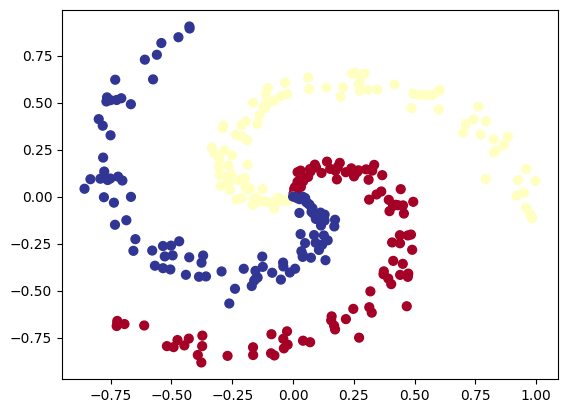

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [5]:
import torch
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.LongTensor) 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

2023-03-10 08:41:29.806260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 08:41:30.747904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-10 08:41:30.748023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-10 08:41:30.748031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

MulticlassAccuracy()

In [8]:
class SpiralModel(nn.Module):
    def __init__(self, input_feat, output_feat, hidden_layer):
        super().__init__()
        self.sp_layer = nn.Sequential(
                nn.Linear(in_features=input_feat, out_features=hidden_layer),
                nn.ReLU(),
                nn.Linear(in_features=hidden_layer, out_features=hidden_layer),
                nn.ReLU(),
                nn.Linear(in_features=hidden_layer, out_features=output_feat),
                nn.ReLU())
    def forward(self, x):
        return self.sp_layer(x)

sp_model = SpiralModel(input_feat=2,
                       output_feat=4,
                       hidden_layer=10
                      ).to(device)
sp_model

SpiralModel(
  (sp_layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
    (5): ReLU()
  )
)

In [9]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=sp_model.parameters(), lr = 0.01)

In [11]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    sp_model.train()
  
    y_logits = sp_model(X_train) 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

 
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    sp_model.eval()
    with torch.inference_mode():
        test_logits = sp_model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.40 Acc: 0.35 | Test loss: 1.40 Test acc: 0.27
Epoch: 100 | Loss: 0.29 Acc: 0.90 | Test loss: 0.37 Test acc: 0.83
Epoch: 200 | Loss: 0.07 Acc: 0.98 | Test loss: 0.12 Test acc: 0.98
Epoch: 300 | Loss: 0.04 Acc: 0.99 | Test loss: 0.06 Test acc: 1.00
Epoch: 400 | Loss: 0.03 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 500 | Loss: 0.03 Acc: 0.99 | Test loss: 0.03 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00


In [12]:
import numpy as np
# this function has copied from somewhere.
def plot_decision_boundary(model, X, y):
  
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

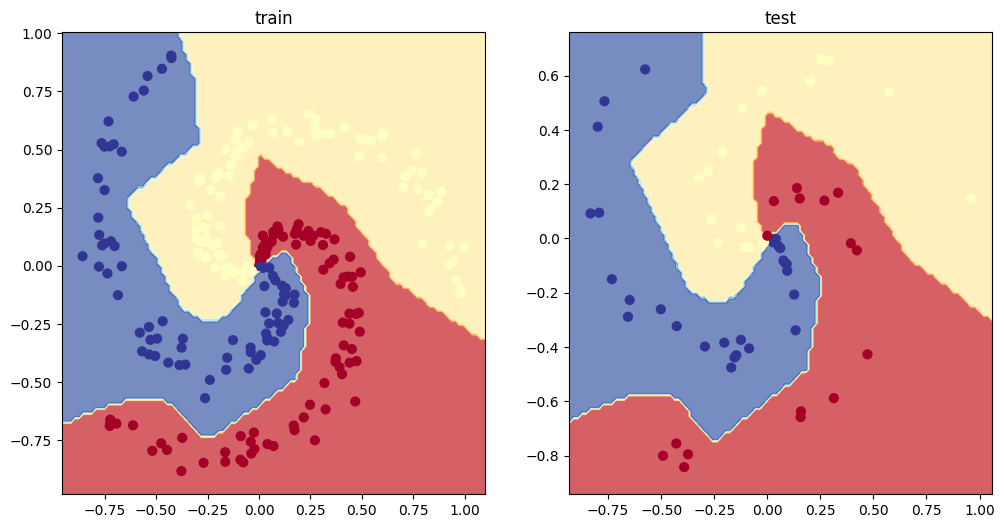

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(sp_model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(sp_model, X_test, y_test)